# Imputation Experiment: KNN for Categorical Data

In this notebook, we will experiment with using a K-Nearest Neighbors (KNN) Classifier to fill missing values in the `internet_service` column.
This is a "Model-Based Imputation" strategy.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

## 1. Prepare Data

In [19]:
# Load Data
df = pd.read_csv('../customer_churn_dataset/train.csv')

# Copy data for experiment
df_impute = df.copy()

# Separate into Train (Has Internet Service) and Missing (NaN)
df_train = df_impute[df_impute['internet_service'].notnull()]
df_missing = df_impute[df_impute['internet_service'].isnull()]

print(f"Training Rows: {len(df_train)}")
print(f"Rows to Impute: {len(df_missing)}")

Training Rows: 14373
Rows to Impute: 1627


## 2. Feature Selection via Correlation (Enhanced)
We will encode ALL features (Categorical and Numerical) to find the best predictors.

In [20]:
# Encode ALL features temporarily to check correlation
df_corr = df_train.copy()
le = LabelEncoder()

# Encode object columns
for col in df_corr.columns:
    if df_corr[col].dtype == 'object':
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Calculate correlation matrix for ALL columns
corr_matrix = df_corr.corr()

# Display correlation with target (internet_service)
# Note: internet_service was encoded in the loop above
target_corr = corr_matrix['internet_service'].sort_values(ascending=False)
print("Correlation with Internet Service:\n", target_corr)

# Select features with high correlation (abs correlation > 0.1)
# We exclude the target itself and customer_id
selected_features = target_corr[abs(target_corr) > 0.1].index.tolist()
selected_features = [f for f in selected_features if f not in ['internet_service', 'customer_id']]

print(f"\nSelected Features for KNN Training: {selected_features}")

Correlation with Internet Service:
 internet_service    1.000000
tenure              0.019274
total_charges       0.016294
contract            0.005950
online_security     0.005673
monthly_charges     0.004727
support_calls       0.004544
payment_method      0.003995
churn               0.001648
tech_support       -0.003650
customer_id        -0.007982
Name: internet_service, dtype: float64

Selected Features for KNN Training: []


## 3. Train KNN Classifier
Training using selected (or default) features.

In [21]:
# Check if selection yielded features, else use Domain Defaults
if not selected_features:
    print("Warning: No features displayed high correlation. Using defaults: Monthly, Total Charges & Tenure.")
    selected_features = ['monthly_charges', 'total_charges', 'tenure']

# 1. Prepare Training Data with Encoding
X_train_raw = df_train[selected_features].copy()
X_missing_raw = df_missing[selected_features].copy()

# Apply Label Encoding to Categorical Selected Features
for col in selected_features:
    if df[col].dtype == 'object':
        le_temp = LabelEncoder()
        combined_data = pd.concat([df_train[col], df_missing[col]], axis=0).astype(str)
        le_temp.fit(combined_data)
        
        X_train_raw[col] = le_temp.transform(df_train[col].astype(str))
        X_missing_raw[col] = le_temp.transform(df_missing[col].astype(str))

# 2. Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_missing = scaler.transform(X_missing_raw)

# Target Variable
y_train = df_train['internet_service']

In [22]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
predicted_services = knn.predict(X_missing)

print("Prediction Complete. Sample predictions:", predicted_services[:10])

Prediction Complete. Sample predictions: ['Fiber' 'DSL' 'DSL' 'DSL' 'Fiber' 'DSL' 'Fiber' 'DSL' 'Fiber' 'Fiber']


## 4. Fill and Visualize Results

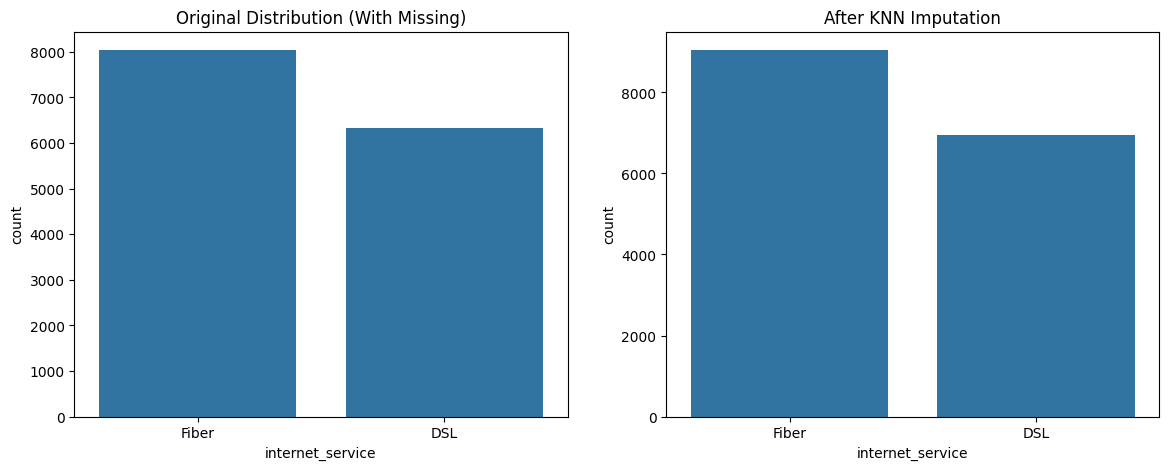

In [23]:
# Fill values in a new column
df_impute.loc[df_impute['internet_service'].isnull(), 'internet_service'] = predicted_services

# Visualize Before vs After
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='internet_service', data=df, ax=ax[0])
ax[0].set_title('Original Distribution (With Missing)')

sns.countplot(x='internet_service', data=df_impute, ax=ax[1])
ax[1].set_title('After KNN Imputation')

plt.show()

In [24]:
# Print new counts
print(df_impute['internet_service'].value_counts())

internet_service
Fiber    9046
DSL      6954
Name: count, dtype: int64
